# Estimating overall rates and yields from pseudo batch transformed data

This tutorial will show how to use the fedbatch data correction package to calculate rates and yields from measurements. We will use simulated data to showcase the workflow. The simulated data here resembles a system where online measurements are available. This could for example to the Satorious AMBR(R) or M2Lab Bio/Robolector cultivation systems.

## loading fedbatch data

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm
import dotenv

os.chdir(dotenv.find_dotenv().replace(".env", ""))
from src.data_correction import pseudobatch_transform_pandas

In [2]:
fedbatch_file = os.path.join("simulated_data", "standard_fed-batch_process.csv")
# At the sampling time the simulation contains a value both before and after the sample was taken.
# When I load the data I keep only the first value, which is the value before the sample was taken.
fedbatch_df = (pd.read_csv(fedbatch_file)
    .drop_duplicates(subset='timestamp', keep='first')
    .reset_index(drop=True) # Reset the index to avoid gaps in index numbers from removed rows.
    .fillna({'sample_volume': 0}) # Fill the sample volume column with 0 when no sample was taken.
)

Lets start with getting an overview of the data that we have imported by look at a part of the dataframe.

In [3]:
(fedbatch_df
    .query('(timestamp > 9.7) & (timestamp < 10.2)')
    .filter(['sample_volume', 'timestamp', 'c_Biomass', 'c_Glucose', 'c_Product', 'v_Volume', 'v_Feed_accum', 'm_Biomass', 'm_Glucose', 'm_Product',])
)

,sample_volume,timestamp,c_Biomass,c_Glucose,c_Product,v_Volume,v_Feed_accum,m_Biomass,m_Glucose,m_Product
162,0.0,9.72973,1.303037,0.075020,0.665867,1015.235064,15.235064,1322.888478,76.162711,676.011317
163,0.0,9.78979,1.310697,0.075018,0.672219,1015.382606,15.382606,1330.858927,76.171557,682.559122
164,0.0,9.84985,1.318401,0.075016,0.678607,1015.531036,15.531036,1338.877205,76.180800,689.146219
165,0.0,9.90991,1.326149,0.075014,0.685031,1015.680361,15.680361,1346.943649,76.190352,695.772886
166,0.0,9.96997,1.333942,0.075013,0.691493,1015.830585,15.830585,1355.058610,76.200099,702.439410
167,100.0,10.00000,1.337854,0.075012,0.694737,1015.906036,15.906036,1359.134400,76.205005,705.787712
168,0.0,10.03003,1.341779,0.075011,0.697991,915.974265,15.974265,1229.034797,68.707889,639.341949
169,0.0,10.09009,1.349662,0.075007,0.704528,916.111339,16.111339,1236.440707,68.714328,645.425980
170,0.0,10.15015,1.357591,0.075001,0.711103,916.249238,16.249238,1243.892012,68.719362,651.547303


This shows some of the columns in the dataframe. 
- `sample_volume` columns contain the sample volume at the given time point. In this dataset, we have online measurements thus more measurements than samples and therefore at most timepoint the sample volume is 0.
- `timestamp` describe the timepoint
- `c_Biomass`, `c_Glucose`, and `c_Product` is the online concentration measurements 
- `v_Volume` is the volume of the bioreactor. **IMPORTANT:** at points where a sample is taken this value represents the volume just **before** the sample was drawn.
- `v_Feed_accum` is the accumulated feed added until that timepoint.
- `m_Biomass`, `m_Glucose`, `m_Product` is the total mass of that species in the reactor, i.e. volume * concentration

The dataframe does contain more columns than those shown, but these simply contain information about the parameters used for simulation. Some of them, e.g. true maximum growth rate, are typically not know in a real experimental setting and some of them are experimental design parameters, e.g. glucose concentration in the feed. For clarity, we will just print them here:

In [4]:
print(fedbatch_df.columns)

Index(['Kc_s', 'mu_max', 'Yxs', 'Yxp', 'Yxco2', 'F0', 'mu0', 's_f',
       'sample_volume', 'timestamp', 'm_Glucose', 'm_Biomass', 'm_Product',
       'm_CO2', 'v_Volume', 'v_Feed_accum', 'c_Glucose', 'c_Biomass',
       'c_Product', 'c_CO2', 'mu_true'],
      dtype='object')


Most often we are not interested in the mass of substrate in the medium, but rather we are interested in the accumulated consumed substrate at any given timepoint. We will calculate this before moving on.

In [5]:
def consumed_substrate(concentration_in_feed, accumulated_feed_volume, measured_substrate_mass, initial_substrate_mass):
    return initial_substrate_mass + accumulated_feed_volume * concentration_in_feed - measured_substrate_mass

glucose_in_feed = fedbatch_df.s_f.iloc[0] # 100 g/L, substrate (glucose) concentration in feed is store in the dataframe 

fedbatch_df['m_Glucose_consumed'] = consumed_substrate(
    concentration_in_feed=glucose_in_feed,
    accumulated_feed_volume=fedbatch_df['v_Feed_accum'],
    measured_substrate_mass=fedbatch_df['m_Glucose'],
    initial_substrate_mass=0
)

To make a more realistic example, we will assume that we only have measurements at the sampling time points. Therefore we create a dataframe which contains these measurement data only.

In [6]:
fedbatch_df_measurement = fedbatch_df.query("sample_volume > 0").copy().reset_index(drop=True)

The dataframe that only have measurements at the sampling points, looks as follows:

In [7]:
(fedbatch_df_measurement
    .filter(['sample_volume', 'timestamp', 'c_Biomass', 'c_Glucose', 'c_Product', 'v_Volume', 'v_Feed_accum', 'm_Biomass', 'm_Glucose', 'm_Product',])
)

,sample_volume,timestamp,c_Biomass,c_Glucose,c_Product,v_Volume,v_Feed_accum,m_Biomass,m_Glucose,m_Product
0,100.0,10.000000,1.337854,0.075012,0.694737,1015.906036,15.906036,1359.134400,76.205005,705.787712
1,100.0,14.545455,2.078116,0.075010,1.308552,928.960902,28.960902,1930.488955,69.681345,1215.593727
2,100.0,19.090909,3.203015,0.075111,2.241303,847.314262,47.314262,2713.960332,63.642770,1899.087680
3,100.0,23.636364,4.879772,0.075020,3.631646,772.816654,72.816654,3771.169156,57.976787,2806.596268
4,100.0,28.181818,7.307921,0.075064,5.645033,707.795685,107.795685,5172.515230,53.129746,3995.530138
5,100.0,32.727273,10.681703,0.075010,8.442525,655.117789,155.117789,6997.773538,49.140520,5530.848452
6,100.0,37.272727,15.109112,0.075015,12.113671,618.291500,218.291500,9341.835286,46.381315,7489.779507
7,100.0,41.818182,20.503292,0.075044,16.586449,601.721795,301.721795,12337.277587,45.155402,9980.428002
8,100.0,46.363636,26.510976,0.075043,21.567936,611.318523,411.318523,16206.650417,45.875096,13184.878944
9,100.0,50.909091,32.568141,0.075049,26.590453,655.738790,555.738790,21356.193361,49.212516,17436.391417


### Overview of the simulation
First let's have a look at the simulated data. Columns starting with m_, c_, and v_ describes mass', concentrations and volumes, respectively.

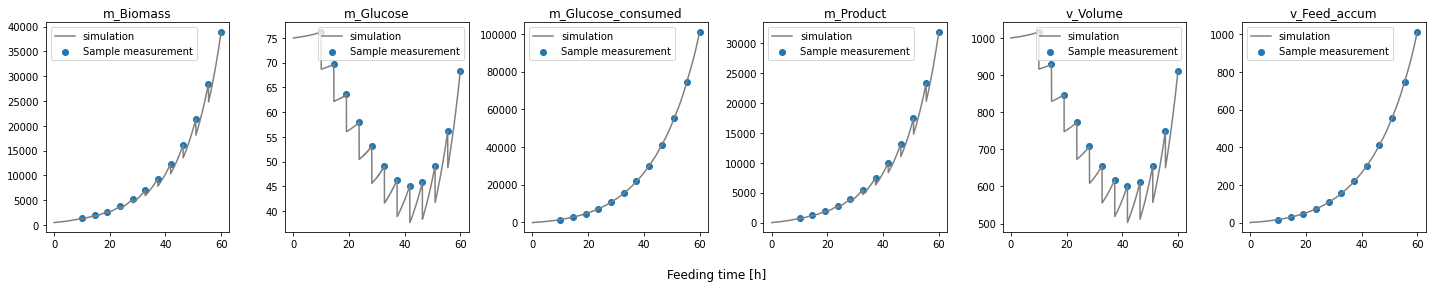

In [8]:
plot_columns = ["m_Biomass", "m_Glucose", "m_Glucose_consumed", "m_Product", "v_Volume", "v_Feed_accum"]

fig, axes = plt.subplots(nrows = 1, ncols = len(plot_columns), figsize=(20, 4))
for ax, column in zip(axes.ravel(), plot_columns):
    ax.plot(fedbatch_df["timestamp"], fedbatch_df[column], label="simulation", color="grey")
    ax.scatter(fedbatch_df_measurement["timestamp"], fedbatch_df_measurement[column], label="Sample measurement")
    ax.title.set_text(column)
    ax.legend()
fig.supxlabel("Feeding time [h]")
fig.tight_layout()

In the simulated data, we clearly see the discrete nature of the product, glucose and biomass mass' and the volume of bioreactor. This is due to sample withdrawal of reactor. This "continuos" time series would be available for some quantities, such as Biomass, O2, CO2, and volume, in some cultivation systems, e.g. Robolector or AMBR systems. Glucose and product measurements will typically only be available as the much sparser measurement points. The pseudo batch transformation can handle both online measurements and sample measurements.

## Applying the pseudo batch transformation

Now we can transform the data. Here I will use a convenience wrapper function that can be applied directly to a Pandas DataFrame, but under the hood this just loops over a list of columns and calls the `pseudobatch_transform()` on each of them.

In [9]:
fedbatch_df_measurement[["c_Biomass_pseudo", "c_Glucose_pseudo", "c_Product_pseudo", "c_CO2_pseudo"]] = pseudobatch_transform_pandas(
    fedbatch_df_measurement,
    measured_concentration_colnames=["c_Biomass", "c_Glucose", "c_Product", "c_CO2"],
    reactor_volume_colname="v_Volume",
    accumulated_feed_colname="v_Feed_accum",
    sample_volume_colname="sample_volume",
    concentration_in_feed=[0, glucose_in_feed, 0, 0],
)

The pseudo batch transformed data is immediately in the units of "pseudo concentration". Since it is a concentration it is numerically smaller that the measured mass'. Thus, if we want to compare the original data with the pseudo batch transformed we can calculate the pseudo mass by multiplying the pseudo concentration with the initial volume of the fed-batch process.

The species that are not fed can be compared in mass and pseudo mass values. But for the species which are fed, e.g. glucose, it makes sense to compare the "consumed" time series. Therefore, we will now calculate the the consumed pseudo concentration and mass for the substrate (glucose).

In [10]:
intial_glucose_concentration = 0
fedbatch_df_measurement['c_Glucose_consumed_pseudo'] = intial_glucose_concentration - fedbatch_df_measurement['c_Glucose_pseudo']

In [11]:
fedbatch_df_measurement[["m_Biomass_pseudo", "m_Glucose_consumed_pseudo", "m_Product_pseudo", "m_CO2_pseudo"]] = fedbatch_df_measurement[["c_Biomass_pseudo", "c_Glucose_consumed_pseudo", "c_Product_pseudo", "c_CO2_pseudo"]] * fedbatch_df["v_Volume"].iloc[0]

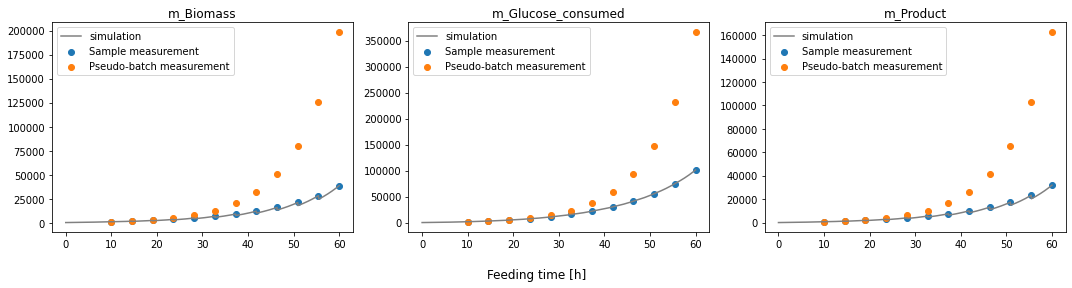

In [12]:
plot_columns = ["m_Biomass", "m_Glucose_consumed", "m_Product"]

fig, axes = plt.subplots(nrows = 1, ncols = len(plot_columns), figsize=(15, 4))
for ax, column in zip(axes.ravel(), plot_columns):
    ax.plot(fedbatch_df["timestamp"], fedbatch_df[column], label="simulation", color="grey")
    ax.scatter(fedbatch_df_measurement["timestamp"], fedbatch_df_measurement[column], label="Sample measurement")
    ax.scatter(fedbatch_df_measurement["timestamp"], fedbatch_df_measurement[column + '_pseudo'], label="Pseudo-batch measurement")
    ax.title.set_text(column)
    ax.legend()
fig.supxlabel("Feeding time [h]")
fig.tight_layout()


## Calculate growth rate

Now we are ready to estimate the growth rate. To estimate the growth rate we will use a log-linear model.
$$
log(C^{\star}_{Biomass}) = a + \hat\mu * t
$$
where $C^{\star}_{Biomass}$ is the pseudo batch transformed biomass concentration, and $\hat\mu$ is the growth rate estimate. Because we will fit several linear models, we make a small convenience function to simplify the code.

In [13]:
def fit_ols_model(formula_like: str, data: pd.DataFrame) -> sm.regression.linear_model.RegressionResultsWrapper:
    y, X = dmatrices(formula_like, data)
    model = sm.OLS(endog=y, exog=X)
    res = model.fit()
    return res

Now we can fit the growth rate for both the transform and raw biomass data.

In [14]:
res_mu_hat_pseudo = fit_ols_model("np.log(m_Biomass_pseudo) ~ timestamp", fedbatch_df_measurement)
res_mu_hat_raw = fit_ols_model("np.log(m_Biomass) ~ timestamp", fedbatch_df_measurement)

And visualize the data and the fitted linear models.

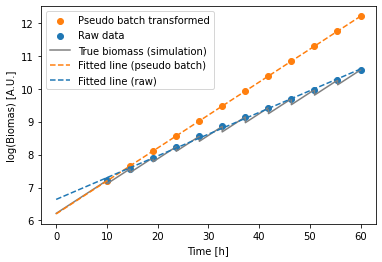

Fitted growth rate from pseudo batch transformed biomass: 0.10000016643815145
Fitted growth rate from raw biomass: 0.06597174185227486
True simulated growth rate 0.1000104046529978


In [15]:
## plot the data and the fitted line
plt.scatter(fedbatch_df_measurement['timestamp'], fedbatch_df_measurement['m_Biomass_pseudo'].transform(np.log), label='Pseudo batch transformed', color = "C1")
plt.scatter(fedbatch_df_measurement['timestamp'], fedbatch_df_measurement['m_Biomass'].transform(np.log), label='Raw data', color = "C0")
plt.plot(fedbatch_df['timestamp'], fedbatch_df['m_Biomass'].transform(np.log), label='True biomass (simulation)', color='grey')

# Drawing linear regression line
x_pred = sm.add_constant(fedbatch_df['timestamp']) 
y_pred_pseudo = res_mu_hat_pseudo.predict(x_pred) 
y_pred_raw = res_mu_hat_raw.predict(x_pred) 
plt.plot(fedbatch_df['timestamp'], y_pred_pseudo, color='C1', linestyle = 'dashed', label='Fitted line (pseudo batch)')
plt.plot(fedbatch_df['timestamp'], y_pred_raw, color='C0', linestyle = 'dashed', label='Fitted line (raw)')
plt.legend()
plt.ylabel("log(Biomas) [A.U.]")
plt.xlabel("Time [h]")
plt.show()

print("Fitted growth rate from pseudo batch transformed biomass: " + str(res_mu_hat_pseudo.params[1]))
print("Fitted growth rate from raw biomass: " + str(res_mu_hat_raw.params[1]))
print("True simulated growth rate " + str(fedbatch_df_measurement["mu_true"].iloc[-1]))

We see that the growth rate fitted to the pseudo batch data is very close to the true growth rate. The small difference originates from the fact that the growth rate in the simulation is not truly constant, but changes slightly due to substrate concentration changing slightly. On the other hand the growth rate estimate from the raw measurements in very wrong.

## Estimating biomass yield coefficients
The biomass yield coefficients can also be estimated from the pseudo batch transformed data. Here we will fit a normal linear model to obtain a single overall yield estimate for each species.
$$
C^{\star}_{Species} = a + \hat Y_{xspecies} * t
$$

Where $C^{\star}_{Species}$ is the pseudo concetration of a species and the $\hat Y_{xspecies}$ is the biomass yield coefficient (in units $\frac{g_{Species}}{g_{Biomass}}$).

We will start by estimating the substrate biomass yield coefficient.

In [16]:
res_yxs_noncorrected = fit_ols_model(formula_like = "m_Glucose_consumed ~ m_Biomass", data= fedbatch_df_measurement)
res_yxs_corrected = fit_ols_model(formula_like = "m_Glucose_consumed_pseudo ~ m_Biomass_pseudo", data= fedbatch_df_measurement)

print(f"Fitted Yxs from raw data: {res_yxs_noncorrected.params[1].round(5)}")
print(f"Fitted Yxs from pseudo batch transformed data: {res_yxs_corrected.params[1].round(5)}")
print(f"True Yxs: {fedbatch_df.Yxs.iloc[0].round(5)}")

Fitted Yxs from raw data: 2.68841
Fitted Yxs from pseudo batch transformed data: 1.85
True Yxs: 1.85


Here we see a large improvement in the estimate from using the pseudo batch transformed data. Now let's move on the product biomass yield coefficient.

In [17]:
res_yxp_noncorrected = fit_ols_model(formula_like = "m_Product ~ m_Biomass", data= fedbatch_df_measurement)
res_yxp_corrected = fit_ols_model(formula_like = "m_Product_pseudo ~ m_Biomass_pseudo", data= fedbatch_df_measurement)

print(f"Fitted Yxp from raw data: {res_yxp_noncorrected.params[1].round(5)}")
print(f"Fitted Yxp from pseudo batch transformed data: {res_yxp_corrected.params[1].round(5)}")
print(f"True Yxp: {fedbatch_df.Yxp.iloc[0].round(5)}")

Fitted Yxp from raw data: 0.82967
Fitted Yxp from pseudo batch transformed data: 0.82151
True Yxp: 0.82151


Again the estimate based on the pseudo batch transformed data is more accurate that the estimate based on the raw data. In this case the difference the improvement of the estimate with the pseudo batch data is not as significant as for the growth rate and substrate yield coefficient, never the less it is still more accurate.

It is difficult to make a meaningful plots to compare the yield coefficient estimates, so we will skip that and end the tutorial here. For more advanced usage pseudo batch transformation move on the other example notebooks.